## Imports

In [1]:
import bilby
import gwpopulation as gwpop
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner
import seaborn as sns

from astropy import cosmology, units
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

from bilby.core.prior import Uniform, Constraint, PriorDict, LogUniform
from bilby.gw.prior import BBHPriorDict
from gwpopulation.models import mass, spin

xp = gwpop.cupy_utils.xp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Model B - Gaussian

This paper uses `Overall_posterior`.

In [2]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [3]:
file = 'GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', '170729', '170809', '170814', 
          '170818', '170823']

posteriorsB = []
priorsB = []
event_name = []

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
    posteriorsB.append(_posterior)
    event_name.append(event)

In [4]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

In [5]:
for posterior in posteriorsB:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']

### Sampling effective spins ($\chi_{\mathrm{eff}}$) by parameter estimation

$$\chi_{\mathrm{eff}} = \frac{a_1 m_1 cost_1 + a_2 m_2 cost_2}{m_1 + m_2}$$

For each gravitational wave we obtain a set of discrete samples p($\chi_{\mathrm{eff}}$|data) (given by `posterior['chieff']` here)

Effective spins are drawn from a simple truncated Gaussian.

In [6]:
def chieff(a1, a2, m1, m2, cost1, cost2):
    chi_eff = (a1*m1*cost1 + a2*m2*cost2)/(m1+m2)
    return chi_eff

In [7]:
for posterior in posteriorsB:
    posterior['chi_eff'] = chieff(posterior['a_1'], posterior['a_2'], 
                                 posterior['mass_1'], posterior['mass_2'], 
                                 posterior['cos_tilt_1'], posterior['cos_tilt_2'])

In [9]:
posteriorsB[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_1,mass_2,mass_ratio,chi_eff
0,40.823686,26.440697,429.439630,0.720602,0.536915,-0.591917,0.188768,0.090895,37.422188,24.237614,0.647680,-0.219031
1,34.626875,34.212308,337.154490,0.238156,0.410068,-0.076179,-0.517005,0.072273,32.292953,31.906329,0.988028,-0.114491
2,36.142271,33.174642,487.316326,0.297883,0.187064,-0.335351,-0.821574,0.102359,32.786286,30.094216,0.917890,-0.125640
3,41.569619,31.876132,488.540224,0.347413,0.059700,0.109706,-0.500742,0.102600,37.701443,28.909964,0.766813,0.008597
4,37.869125,33.759950,463.788715,0.147665,0.086681,-0.761297,0.988754,0.097718,34.498038,30.754659,0.891490,-0.019038
...,...,...,...,...,...,...,...,...,...,...,...,...
8345,40.383795,31.959753,460.559361,0.088515,0.577331,0.870492,-0.264759,0.097079,36.810276,29.131669,0.791400,-0.024515
8346,38.164225,35.639218,449.985818,0.122339,0.190940,0.783595,0.267030,0.094983,34.853703,32.547725,0.933838,0.074193
8347,37.670359,34.004716,513.756334,0.439794,0.470269,-0.208949,0.113237,0.107545,34.012487,30.702786,0.902692,-0.023033
8348,36.746741,35.672009,399.113830,0.163340,0.423884,0.160240,0.171165,0.084824,33.873472,32.882775,0.970753,0.049020


Here, simulating the LALprior for $\chi_{\mathrm{eff}}$:

In [9]:
simulated_LALprior = bilby.gw.prior.BBHPriorDict()

# mass -- these are detector frame masses
simulated_LALprior["mass_1"] = Uniform(minimum = 0, maximum = 1, latex_label = 'm1')
simulated_LALprior["mass_2"] = Uniform(minimum = 0, maximum = 1, latex_label = 'm2')
simulated_LALprior["mass_ratio"] = Constraint(minimum = 0, maximum = 1)

# spin
simulated_LALprior["a_1"] = Uniform(minimum = 0, maximum = 1, latex_label = 'a1')
simulated_LALprior["a_2"] = Uniform(minimum = 0, maximum = 1, latex_label = 'a2')
simulated_LALprior["cos_tilt_1"] = Uniform(minimum = -1, maximum = 1, latex_label = 'cost1')
simulated_LALprior["cos_tilt_2"] = Uniform(minimum = -1, maximum = 1, latex_label = 'cost2')

08:13 bilby INFO    : No prior given, using default BBH priors in /home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [10]:
del simulated_LALprior["chirp_mass"]

In [11]:
simulated_LALprior_samples = simulated_LALprior.sample(100000)

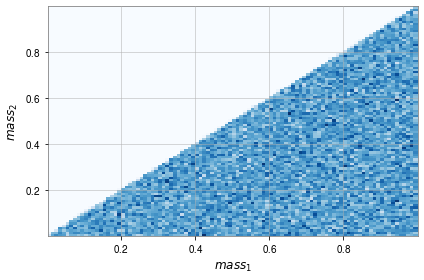

In [12]:
plt.hist2d(simulated_LALprior_samples['mass_1'], simulated_LALprior_samples['mass_2'], bins=100, cmap='Blues')
plt.xlabel('$mass_1$')
plt.ylabel('$mass_2$')
plt.tight_layout()
plt.show()
plt.close()

In [13]:
simulated_LALprior_samples = simulated_LALprior.sample(1000)
simulated_LALprior_samples["chi_eff"] = chieff(simulated_LALprior_samples["a_1"], 
                                               simulated_LALprior_samples["a_2"], 
                                               simulated_LALprior_samples["mass_1"], 
                                               simulated_LALprior_samples["mass_2"], 
                                               simulated_LALprior_samples["cos_tilt_1"], 
                                               simulated_LALprior_samples["cos_tilt_2"])

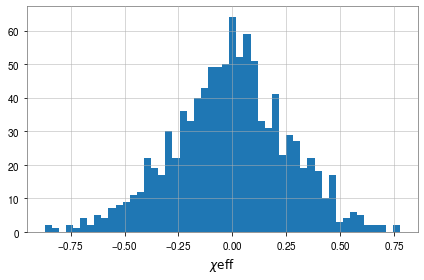

In [14]:
plt.hist(simulated_LALprior_samples['chi_eff'], bins=50)
plt.xlabel('$\\chi{\mathrm{eff}}$')
plt.tight_layout()
plt.show()
plt.close()

<AxesSubplot:>

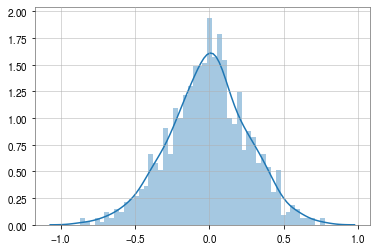

In [16]:
sns.distplot(simulated_LALprior_samples['chi_eff'], bins=50)

Good place to know about KDE https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

Here I just go with the SciPy Gaussian KDE.

In [17]:
from scipy.stats import gaussian_kde

simulated_LAL_chi_prior = gaussian_kde(simulated_LALprior_samples["chi_eff"])

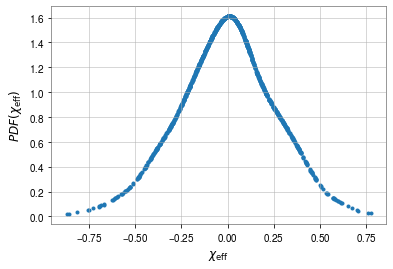

In [18]:
plt.plot(simulated_LALprior_samples["chi_eff"], 
         simulated_LAL_chi_prior(simulated_LALprior_samples["chi_eff"]), '.')
plt.xlabel("$\\chi_{\mathrm{eff}}$")
plt.ylabel("$PDF(\\chi_{\mathrm{eff}})$")
plt.show()

To put it in terms of the notation given <a href = "https://arxiv.org/pdf/2001.06051.pdf">here</a>, this PDF given above is $p_{pe}$($\chi_{\mathrm{eff,j}}$). Now we need to reweight it with $p_{pe}$($m_{1,j}, m_{2,j}, z_j$)

$$p_{pe}(m_1, m_2, z) \propto (1+z)^2 D_L(z)^2  \bigg[ D_c(z) + \frac{c(1+z)}{H(z)}\bigg]$$

To calculate Hubble Parameter https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

In [46]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import astropy

def LALprior_wt(z, chi_eff):
    d_l = cosmo.luminosity_distance(z).to(u.Mpc).value
    d_c = cosmo.comoving_distance(z).to(u.Mpc).value
    h_z = cosmo.efunc(z) * cosmo.H(0).value
    c = astropy.constants.c.to('km/s').value
    weight = (1+z)**2 * d_l**2 * (d_c + (c * (1+z)) / h_z)
    return weight * simulated_LAL_chi_prior(chi_eff)

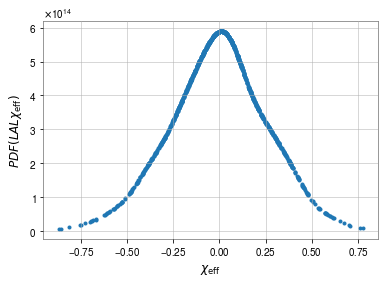

In [47]:
lal = LALprior_wt(4, simulated_LALprior_samples["chi_eff"])
plt.plot(simulated_LALprior_samples["chi_eff"], lal, '.')
plt.xlabel("$\\chi_{\mathrm{eff}}$")
plt.ylabel("$PDF(LAL\\chi_{\mathrm{eff}})$")
plt.show()

Next we need $p$($\chi_{\mathrm{eff}, j} | \mu, \sigma^2 $) and reweight it with $p_{astro}$($m_{1,j}, m_{2,j}, z_j$)

$$p_{astro}(m_1, m_2, z) \propto \frac{(1+z)^{1.7}}{m_1 (m_1 - M_{min})} \frac{dV_c}{dz}$$

To calculate $\frac{dV_c}{dz}$ :  https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

In [54]:
def astro_prior_wt(m1, z):
    mmin = 5
    dVc_dz = cosmo.differential_comoving_volume(z).to(u.Mpc**3/u.sr).value * 4 * pi
    weight = (1+z)**1.7 / (m1 * (m1 - mmin)) * dVc_dz
    return weight

In [57]:
for posterior in posteriorsB:
    posterior["LALprior"] = LALprior_wt(posterior["redshift"], posterior["chi_eff"]) 
    posterior["astro_prior"] = astro_prior_wt(posterior["mass_1"], posterior["redshift"])
    posterior["weight"] = posterior["astro_prior"] / posterior["LALprior"]

In [58]:
posteriorsB[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_1,mass_2,mass_ratio,chi_eff,LALprior,astro_prior,weight
0,40.823686,26.440697,429.439630,0.720602,0.536915,-0.591917,0.188768,0.090895,37.422188,24.237614,0.647680,-0.219031,1.098422e+09,7.880192e+06,0.007174
1,34.626875,34.212308,337.154490,0.238156,0.410068,-0.076179,-0.517005,0.072273,32.292953,31.906329,0.988028,-0.114491,8.634723e+08,6.784153e+06,0.007857
2,36.142271,33.174642,487.316326,0.297883,0.187064,-0.335351,-0.821574,0.102359,32.786286,30.094216,0.917890,-0.125640,1.926198e+09,1.339410e+07,0.006954
3,41.569619,31.876132,488.540224,0.347413,0.059700,0.109706,-0.500742,0.102600,37.701443,28.909964,0.766813,0.008597,2.375729e+09,9.945097e+06,0.004186
4,37.869125,33.759950,463.788715,0.147665,0.086681,-0.761297,0.988754,0.097718,34.498038,30.754659,0.891490,-0.019038,2.084690e+09,1.090043e+07,0.005229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,40.383795,31.959753,460.559361,0.088515,0.577331,0.870492,-0.264759,0.097079,36.810276,29.131669,0.791400,-0.024515,2.041751e+09,9.346400e+06,0.004578
8346,38.164225,35.639218,449.985818,0.122339,0.190940,0.783595,0.267030,0.094983,34.853703,32.547725,0.933838,0.074193,1.832334e+09,1.005704e+07,0.005489
8347,37.670359,34.004716,513.756334,0.439794,0.470269,-0.208949,0.113237,0.107545,34.012487,30.702786,0.902692,-0.023033,2.625518e+09,1.368816e+07,0.005214
8348,36.746741,35.672009,399.113830,0.163340,0.423884,0.160240,0.171165,0.084824,33.873472,32.882775,0.970753,0.049020,1.461985e+09,8.483864e+06,0.005803


<AxesSubplot:xlabel='weight'>

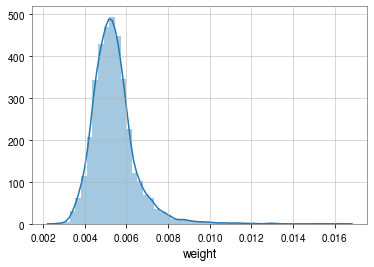

In [62]:
sns.distplot(posteriorsB[0]["weight"], bins = 50)

## Hyper-prior model

### $\chi_{\mathrm{eff}}$ 

Effective spins are drawn from a simple truncated Gaussian.

In [10]:
from scipy.special import erf

def truncated_gaussian(dataset, mu, var):
    norm = (2/(np.pi*var))**0.5 * (erf((1-mu)/(2*var)**0.5) + erf((1+mu)/(2*var)**0.5))**(-1)
    prob = np.exp(-(dataset['chi_eff'] - mu)**2 / (2 * var))
    return norm*prob

In [85]:
# def modelB(dataset, mu, sigma):
#     # Truncated Gaussian for chi_eff
#     prob = gwpop.utils.truncnorm(dataset['chi_eff'], mu = mu_chieff, sigma = sigma_chieff, low = -1, high = 1)
#     return prob

In [11]:
chieff_prior = PriorDict(dict(mu = Uniform(minimum = -1, maximum = 1, latex_label ='$\\mu_{chi}$'),
                              var = Uniform(minimum = 0, maximum = 1, latex_label ='$\\sigma_{chi}$')))

In [12]:
likelihoodB = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriorsB, 
                                                     hyper_prior = truncated_gaussian)

21:49 bilby INFO    : No prior values provided, defaulting to 1.


In [13]:
!which latex

/usr/bin/latex


In [14]:
likelihoodB.parameters.update(chieff_prior.sample())
# likelihoodB.log_likelihood_ratio()

resultB = bilby.run_sampler(likelihood = likelihoodB, priors = chieff_prior, sampler='dynesty', nlive=10, 
                           label = 'd1', outdir = 'd1', clean = True)

21:49 bilby INFO    : Running for label 'd1', output will be saved to 'd1'
21:49 bilby INFO    : Search parameters:
21:49 bilby INFO    :   mu = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_{chi}$', unit=None, boundary=None)
21:49 bilby INFO    :   var = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\sigma_{chi}$', unit=None, boundary=None)
21:49 bilby INFO    : Single likelihood evaluation took 1.609e-03 s


0it [00:00, ?it/s]

21:49 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 10, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 6, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f8bfb627ee0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
21:49 bilby INFO    : Checkpoint every check_point_delta_t = 600s
21:49 bilby INFO    : Using dynesty version 1.0.1
21:49 bilby INFO    : Generating initial points from the prior


123it [00:33,  4.65it/s, bound:76 nc:109 ncall:1.9e+04 eff:0.6% logz-ratio=-0.41+/-1.15 dlogz:0.100>0.1]

21:49 bilby INFO    : Written checkpoint file d1/d1_resume.pickle


123it [00:35,  3.42it/s, bound:76 nc:  1 ncall:1.9e+04 eff:0.7% logz-ratio=-0.33+/-1.17 dlogz:0.008>0.1]

21:50 bilby INFO    : Sampling time: 0:00:33.722526
21:50 bilby INFO    : Summary of results:
nsamples: 133
ln_noise_evidence:    nan
ln_evidence:    nan +/-  1.168
ln_bayes_factor: -0.335 +/-  1.168



In [15]:
resultB.plot_corner()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/home/deepnika.jain/.cache/matplotlib/tex.cache/69940c14ae20d0708b4617e81d13d0
52.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)

! LaTeX Error: Command \mathdefault already defined.
               Or name \end... illegal, see p.192 of the manual.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.11 \newcommand{\mathdefault}[1][]{}
                                     
No pages of output.
Transcript written on 69940c14ae20d0708b4617e81d13d052.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/home/deepnika.jain/.cache/matplotlib/tex.cache/69940c14ae20d0708b4617e81d13d0
52.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)

! LaTeX Error: Command \mathdefault already defined.
               Or name \end... illegal, see p.192 of the manual.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.11 \newcommand{\mathdefault}[1][]{}
                                     
No pages of output.
Transcript written on 69940c14ae20d0708b4617e81d13d052.log.




<Figure size 396x396 with 4 Axes>

###  IGNORE THIS --- Joint mass and redshift model:

$$p_{astro}(m_1, m_2, z) \propto \frac{(1+z)^{1.7}}{m_1(m_1 - M_{min})} \frac{dV_c}{dz}$$

where $m_1$ and $m_2$ are source frame masses.

As a first step, we assume that the underlying mass distribution does not vary across cosmic time, so that we can factor the joint mass-redshift distribution as:

$$p(m_1, m_2, z) = p(m_1, m_2) p(z)$$

This assumption may break down over a large range of redshifts, as many formation scenarios predict some dependence of the mass distribution on the merger redshift. However, LIGO is only sensitive to redshifts z <~ 1.5, for which this is a good approximation. 

<br>

<font color = 'green'>
I am highly skeptical about my implementation of the mass model. Please suggest corrections. Note that this model does not impose a maximum mass cutoff.
</font>

This is the model given in gwpop.models.redshift:

$$p(z|\gamma, \kappa, z_p) \propto \frac{1}{1 + z}\frac{dV_c}{dz} \psi(z|\gamma, \kappa, z_p)$$

$$\psi(z|\gamma, \kappa, z_p) = \frac{(1 + z)^\gamma}{1 + (\frac{1 + z}{1 + z_p})^\kappa}$$

However, I rewrote its simplified version here, (to account for f(z) as in https://arxiv.org/pdf/1805.10270.pdf (9))